# This file will contain Graph data and implementations.

In [8]:
import networkx as nx
import pandas as pd
from scipy.spatial import KDTree

In [9]:
# Don't run this, it will kill your machine. Too many points to be easily assessed.
def interpolate_data_set():
    import pandas as pd
    import numpy as np
    from scipy.interpolate import RBFInterpolator
    carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
    carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
    grid_points = carrauntoohil_data_set[['latitude','longitude']].values
    grid_elevations = carrauntoohil_data_set['elevation'].values
    path_points = carrauntoohil_path_data[['latitude', 'longitude']].values
    path_elevations = carrauntoohil_path_data['elevation'].values
    combined_points = np.vstack([grid_points, path_points])
    combined_elevations = np.hstack([grid_elevations, path_elevations])
    rbf_interpolator = RBFInterpolator(combined_points, combined_elevations, smoothing=0.1)
    min_lat, max_lat = min(combined_points[:,0]), max(combined_points[:,0])
    min_long, max_long = min(combined_points[:,1]), max(combined_points[:,1])
    resolution = 0.001
    lat_grid = np.arange(min_lat, max_lat, resolution)
    long_grid = np.arange(min_long, max_long, resolution)
    lat_mesh, long_mesh = np.meshgrid(lat_grid, long_grid)
    points = np.column_stack([lat_mesh.flatten, long_mesh.flatten()])
    interpolated_elevations = rbf_interpolator(points)
    elevation_grid = interpolated_elevations.reshape(long_mesh.shape)
    return elevation_grid
# interpolate_data_set() # DO NOT RUN THIS.

In [10]:
def create_graph():
    # Import data, combine into one Graph.
    carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
    carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
    combined_data_set = pd.concat([carrauntoohil_data_set, carrauntoohil_path_data]).drop_duplicates()
    G = nx.Graph()
    for _, row in combined_data_set.iterrows():
        G.add_node((row['latitude'], row['longitude']), elevation=row['elevation'])

    # Use KDTree to create proximity-based edges.
    points = combined_data_set[['latitude', 'longitude']].values
    tree = KDTree(points)
    # Add edges based on proximity
    for i, point in enumerate(points):
        distances, indices = tree.query(point, k=5) # 5 neighbours
        for dist, idx in zip(distances, indices):
            if i != idx:
                G.add_edge(
                    (points[i][0], points[i][1]),
                    (points[idx][0], points[idx][1]),
                    weight=dist
                )
    nx.write_graphml(G, 'my_graph.graphml')
    shortest_path = nx.astar_path(G, source=(51.990047, -9.728633), target=(52.008033, -9.757847), weight='weight')
    print(shortest_path)
create_graph()

[(51.990047, -9.728633), (np.float64(51.990047), np.float64(-9.72877907)), (np.float64(51.990047), np.float64(-9.72892514)), (np.float64(51.990047), np.float64(-9.72907121)), (np.float64(51.990047), np.float64(-9.72921728)), (np.float64(51.99013693), np.float64(-9.72936335)), (np.float64(51.99013693), np.float64(-9.72950942)), (np.float64(51.99013693), np.float64(-9.72965549)), (np.float64(51.99013693), np.float64(-9.72980156)), (np.float64(51.99013693), np.float64(-9.72994763)), (np.float64(51.99022686), np.float64(-9.72994763)), (np.float64(51.99022686), np.float64(-9.7300937)), (np.float64(51.99022686), np.float64(-9.73023977)), (np.float64(51.99022686), np.float64(-9.73038584)), (np.float64(51.99022686), np.float64(-9.73053191)), (np.float64(51.9902901), np.float64(-9.730638)), (np.float64(51.99031678999999), np.float64(-9.73067798)), (np.float64(51.9904401), np.float64(-9.7307485)), (np.float64(51.9904896), np.float64(-9.730837)), (np.float64(51.9905447), np.float64(-9.7309257)), 

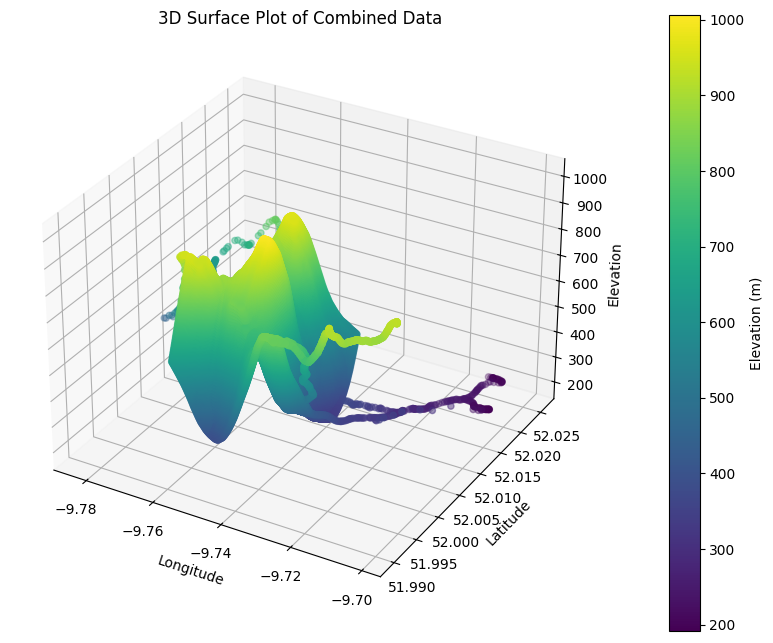

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import numpy as np

# Load Data Set, extract lats, longs, and elevations.
carrauntoohil_data_set = pd.read_csv('carrauntoohil_data_set.csv')
carrauntoohil_path_data = pd.read_csv('path_terrain_set.csv')
combined_data_set = pd.concat([carrauntoohil_data_set, carrauntoohil_path_data]).drop_duplicates()
latitudes = combined_data_set['latitude'].values
longitudes = combined_data_set['longitude'].values
elevations = combined_data_set['elevation'].values

# surface plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(longitudes, latitudes, elevations, c=elevations, cmap='viridis', marker='o')
cbar = plt.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Elevation (m)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Elevation')
ax.set_title('3D Surface Plot of Combined Data')
plt.show()